In [1]:
# ===========================
# Cell 0 — Config (full-QAE, tau30)
# ===========================
DATA_ID = 'mackey_glass_tau30_n200'   # dataset folder name

# Windowing / qubits (4q = 3 latent + 1 trash)
wind_size    = 4
wind_step    = 2
n_latent     = 3
n_trash      = wind_size - n_latent  # = 1
n_extra      = 0                     # keep 0; needed for clean adjoint with SWAP reset

# Ansatz
rot          = 'Rxyz'   # 'Ry' or 'Rxyz'

# Layers: run 5 instances for each of these depths
LAYER_OPTIONS = [1, 3]
INSTANCES_PER_LAYER = [1,2,3,4,5]

# Noise & split
EVAL_SIGMA   = 0.20
split        = 0.75

# Reset mode & differentiation
#   reset_mode: "measure" (default) or "swap" (adds n_trash clean ancillas)
#   diff_method_requested: "adjoint" or "best"
RESET_MODE = "swap"                  # choose: "measure" or "swap"
DIFF_METHOD_REQUESTED = "best"       # choose: "adjoint" or "best"
SIM_BACKEND  = 'default.qubit'       # 'default.qubit' or 'lightning.qubit'
N_EPOCHS = 500                       # Number of training epochs

# Seeds
TRAIN_SEED_BASE = 88000              # per-epoch noisy inputs use base+epoch
TEST_SEED_FIXED = 99123              # fixed seed for scoring

# Logging & paths
LOG_NAME     = 'aintern'
DATA_PATH    = f'{LOG_NAME}/data'
FIGURES_PATH = f'{LOG_NAME}/figures'
TRAIN_PATH   = f'{LOG_NAME}/training'
PARAMS_PATH  = f'{LOG_NAME}/params'
ANALYSIS_PATH= f'{LOG_NAME}/analysis'
BUNDLE_ROOT  = 'qae_runs'

SAVE_PLOTS   = True

In [2]:
# ===========================
# Cell 1 — Imports & utils
# ===========================
import os, sys, time, math, random, json, csv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Repo utils
sys.path.append('.'); sys.path.append('..')
from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg
from qae_utils.Window import ts_add_noise
from qae_utils.Charts import multi_plot_flat_ts
from qae_utils.Tools import draw_circuit

import pennylane as qml
from pennylane import numpy as pnp

# Folders
for p in [FIGURES_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, BUNDLE_ROOT]:
    create_folder_if_needed(p)

np.set_printoptions(suppress=True, precision=6)
plt.rcParams["figure.figsize"] = (6.5, 4)

def set_global_seed(instance_id: int):
    base = 10_000 + int(instance_id)
    random.seed(base + 11)
    np.random.seed(base + 22)
    try:
        pnp.random.seed(base + 33)
    except Exception:
        pass
    return dict(global_seed=base, numpy_seed=base+22, pnp_seed=base+33)

Using data folder: aintern/data/mackey_glass_tau30_n200
Loaded 200 samples; scale = [0.200, 0.800]


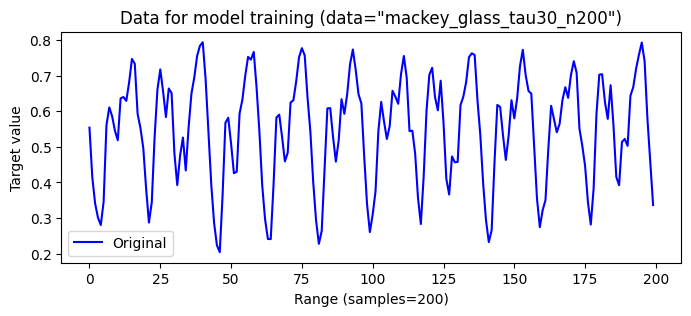

In [3]:
# ===========================
# Cell 2 — Load data & embed (robust paths)
# ===========================
def _find_data_folder(data_id, log_name='aintern', preferred_root=None):
    candidates = []
    if preferred_root:
        candidates.append(preferred_root)
    candidates += [
        f'./{log_name}/data', f'../{log_name}/data', f'../../{log_name}/data',
        './jacobs_examples/aintern/data',
        '../jacobs_examples/aintern/data',
        '../../jacobs_examples/aintern/data',
    ]
    tried = []
    for root in candidates:
        folder = os.path.join(root, data_id)
        info_p = os.path.join(folder, 'info.json')
        x_p    = os.path.join(folder, 'x_org.arr')
        y_p    = os.path.join(folder, 'y_org.arr')
        tried.append(folder)
        if os.path.isdir(folder) and all(os.path.exists(p) for p in (info_p, x_p, y_p)):
            return folder
    raise FileNotFoundError("Could not find dataset folder.\n"
                            f"DATA_ID='{data_id}'. Tried:\n - " + "\n - ".join(tried))

DATA_FOLDER   = _find_data_folder(DATA_ID, log_name=LOG_NAME, preferred_root=DATA_PATH)
info          = read_json_file(f'{DATA_FOLDER}/info.json')
X             = read_ts_file(f'{DATA_FOLDER}/x_org.arr').astype(int)
y             = read_ts_file(f'{DATA_FOLDER}/y_org.arr')

scale_low  = float(info['scale_low'])
scale_high = float(info['scale_high'])

print(f'Using data folder: {DATA_FOLDER}')
print(f'Loaded {len(y)} samples; scale = [{scale_low:.3f}, {scale_high:.3f}]')

multi_plot_flat_ts([y], X_list=[0], colors=['blue'], labels=['Original'],
                   lines=['solid'], legend_cols=1, rcParams=(8, 3),
                   xlabel=f'Range (samples={len(y)})',
                   title=f'Data for model training (data="{DATA_ID}")')

In [4]:
# ===========================
# Cell 3 — FULL-QAE, with reset_mode switch
# ===========================
n_qubits = wind_size
n_data   = n_qubits
base_wires  = list(range(n_latent + n_trash + n_extra))

def full_qae_shape(n_latent, n_trash, n_extra=0, n_layers=1, rot='Ry'):
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    elif rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    return shape

def _entangler_shape(n_layers, n_wires, rot='Ry'):
    if rot == 'Ry':
        return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif rot == 'Rxyz':
        return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)

def _entangler(anz_wires, weights, rot='Ry'):
    if rot == 'Ry':
        qml.BasicEntanglerLayers(weights, wires=anz_wires, rotation=qml.RY)
    elif rot == 'Rxyz':
        qml.StronglyEntanglingLayers(weights, wires=anz_wires)

def make_full_qae_callable(wires, ancilla_wires, n_latent, n_trash, n_extra, n_layers=1,
                           rot='Ry', add_outseq=False, invert_dec=True, reset_mode="measure"):
    latent_wires = wires[0:n_latent]
    trash_wires  = wires[n_latent:n_latent+n_trash]
    extra_wires  = wires[n_latent+n_trash:]
    data_wires   = latent_wires + trash_wires
    anz_wires    = latent_wires + trash_wires + extra_wires

    def _sequence_encoder(wires, inputs):
        n_inputs = len(inputs)
        for w in wires:
            if w > n_inputs-1:
                qml.RY(0, wires=w)
            else:
                qml.RY(inputs[w], wires=w)

    def _full_qae(weights, inputs):
        _sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)

        enc_weights_shape = _entangler_shape(n_layers, len(anz_wires), rot=rot)
        dec_weights_shape = enc_weights_shape

        enc_weights = weights[:n_layers].reshape(enc_weights_shape)
        dec_weights = weights[n_layers:].reshape(dec_weights_shape)

        _entangler(anz_wires, enc_weights, rot=rot)

        qml.Barrier(wires)
        if reset_mode == "measure":
            for w in trash_wires: qml.measure(w, reset=True)
            for w in extra_wires: qml.measure(w, reset=True)
        elif reset_mode == "swap":
            anc_trash = ancilla_wires[:n_trash]
            anc_extra = ancilla_wires[n_trash:n_trash + n_extra]
            for t, a in zip(trash_wires, anc_trash): qml.SWAP(wires=[t, a])
            for e, a in zip(extra_wires, anc_extra): qml.SWAP(wires=[e, a])
        else:
            raise ValueError(f"Unknown reset_mode={reset_mode!r}")
        qml.Barrier(wires)

        if invert_dec:
            qml.adjoint(_entangler)(anz_wires, dec_weights, rot=rot)
        else:
            _entangler(anz_wires, enc_weights, rot=rot)
        qml.Barrier(wires)

        if add_outseq:
            qml.adjoint(_sequence_encoder)(data_wires, inputs)

        return [qml.expval(qml.PauliZ(wires=w)) for w in data_wires]

    return _full_qae

def choose_diff_method(reset_mode, requested):
    if reset_mode == "swap" and requested == "adjoint":
        return "adjoint"
    if reset_mode == "measure" and requested == "adjoint":
        print("[Info] adjoint is incompatible with measure-reset → using 'best'.")
    return "best"

shape = full_qae_shape(n_latent, n_trash, n_extra, n_layers=1, rot=rot)  # base shape for one layer setting
print(f'Base FULL-QAE shape (per L): {shape}, encoder+decoder layers = 2*L')

Base FULL-QAE shape (per L): (2, 4, 3), encoder+decoder layers = 2*L


In [5]:
# ===========================
# Cell 4 — Training loop + helpers
# ===========================
def mse_cost_on_tensors(targets, predictions):
    cost = 0
    vals = 0
    for i in range(len(targets)):
        for w in range(len(targets[i])):
            cost = cost + (targets[i][w] - predictions[i][w]) ** 2
            vals += 1
    cost = cost / vals
    return cost

def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2, range_low=0.2, range_high=0.8, seed=0):
    y_noisy = ts_add_noise(y, noise=noise, noise_type='normal', clip=False,
        range_low=range_low, range_high=range_high, seed=seed)
    y_ts = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(y_ts))])
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = pnp.tensor(X_train_ts, requires_grad=False)
    y_train_tens = pnp.tensor(y_train_ts, requires_grad=False)
    X_test_tens  = pnp.tensor(X_test_ts, requires_grad=False)
    y_test_tens  = pnp.tensor(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

def cost_fun_gen_on_tensors(model, cost_fun):
    def _cost_fun(params, inputs, targets):
        preds = [model(params, x) for x in inputs]
        return cost_fun(targets, preds)
    return _cost_fun

def train_with_noise(model, X, y, loss_fun, optimizer, n_epochs, init_weights=None, 
                     log_interv=1, prompt_fract=0.1, start_time=0, seed_base=88000,
                     wind_size=8, wind_step=4, noise=0.0, weight_scaler=0.1):
    if init_weights is None:
        init_weights = pnp.array(np.random.uniform(high=np.pi, size=model.shape))*weight_scaler
        init_weights.requires_grad = True
    params = init_weights.copy()

    cost_fun  = cost_fun_gen_on_tensors(model, loss_fun)
    hist_cost = []
    hist_params = []

    if start_time == 0: start_time = time.time()

    for iter in range(n_epochs):
        _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0,
            wind_size=wind_size, wind_step=wind_step, range_low=scale_low, range_high=scale_high)

        _, X_noisy_tens, _, _ = create_sw_tens(X, y, noise=noise, seed=seed_base + iter,
            wind_size=wind_size, wind_step=wind_step, range_low=scale_low, range_high=scale_high)

        params, cost = optimizer.step_and_cost(lambda p: cost_fun(p, X_noisy_tens, y_pure_tens), params)

        if iter % log_interv == 0:
            hist_cost.append(float(cost))
            hist_params.append(pnp.array(params))

        if (prompt_fract == 0) or (iter % max(1,int(prompt_fract*n_epochs)) == 0):
            elapsed_time = int(time.time()-start_time)
            print(f'Iter: {iter:03d} ({elapsed_time:04d} sec) cost={float(cost):.6f}')

    min_cost = float(np.min(hist_cost))
    min_iter = int(np.argmin(hist_cost))
    print(f'\nTraining completed: epochs={n_epochs}, min cost={min_cost:.6f} @ {min_iter}\n')
    return hist_cost, hist_params, init_weights, (min_iter, min_cost)

# --- eval helpers
def _flatten_avg(windows):
    return ts_wind_flatten_avg(np.asarray(windows), wind_step)

def _mse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.mean((a - b) ** 2))

def windows_from_seed(y_vec, sigma, seed):
    y_noisy = ts_add_noise(y_vec, noise=sigma, noise_type='normal', clip=False,
                           range_low=scale_low, range_high=scale_high, seed=seed)
    win_clean = ts_wind_make(y_vec,   wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(win_clean))])
    _, tr_clean, _, te_clean = ts_wind_split(X_ts, win_clean, split)
    _, tr_noisy, _, te_noisy = ts_wind_split(X_ts, win_noisy, split)
    return np.asarray(tr_clean), np.asarray(tr_noisy), np.asarray(te_clean), np.asarray(te_noisy)

def Z_to_values_autograd(z_all):
    z = pnp.clip(pnp.asarray(z_all), -0.999999, 0.999999)
    theta = pnp.arccos(z)            # in [0, pi]
    v01   = theta / pnp.pi           # in [0, 1]
    return v01 * (scale_high - scale_low) + scale_low

def run_qnode_series(model, params, windows):
    outs = []
    for w in windows:
        z = model(params, w)        # z already in [-1, 1]
        outs.append(np.asarray(z))
    return np.stack(outs)

In [6]:
# ===========================
# Cell 5 — Circuit PNG renderer (FIXED)
# ===========================
def render_and_save_circuit_fullqae(L, weights_vec, reset_mode, save_dir, inst,
                                    style="pennylane", level="device",
                                    fname_prefix="circuit_fullqae"):
    n_anc = (n_trash + n_extra) if reset_mode == "swap" else 0
    dev = qml.device(SIM_BACKEND, wires=len(base_wires) + n_anc, shots=None)

    ancilla_wires = list(range(len(base_wires), len(base_wires) + n_anc))
    qae_call = make_full_qae_callable(
        wires=base_wires, ancilla_wires=ancilla_wires,
        n_latent=n_latent, n_trash=n_trash, n_extra=n_extra,
        n_layers=L, rot=rot, add_outseq=False, invert_dec=True, reset_mode=reset_mode
    )
    qnode = qml.QNode(qae_call, dev)

    x_dummy = pnp.zeros(wind_size, dtype=float)
    qml.drawer.use_style(style)
    fig_func = qml.draw_mpl(qnode, decimals=2, level=level)
    fig, ax = fig_func(weights_vec, x_dummy)
    ax.set_title(f'FULL-QAE (L={L}, inst={inst}, reset={reset_mode})')

    save_dir = Path(save_dir); save_dir.mkdir(parents=True, exist_ok=True)
    out_png = save_dir / f"{fname_prefix}_L{L}_inst{int(inst):02d}.png"
    fig.savefig(out_png, dpi=220, bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)
    return out_png

In [7]:
# ===========================
# Cell 6 — Run all instances (L in {1,3}, 5 per L) & save artifacts
# ===========================
def ensure_dir(p: str | Path) -> Path:
    p = Path(p); p.mkdir(parents=True, exist_ok=True); return p

def arch_tag():
    # e.g. "4q_2l_2t"
    return f"{n_qubits}q_{n_latent}l_{n_trash}t"

ROOT        = ensure_dir(BUNDLE_ROOT)
DATA_ROOT   = ensure_dir(ROOT / DATA_ID)
ARCH_ROOT   = ensure_dir(DATA_ROOT / arch_tag())
CSV_RUNS    = ARCH_ROOT / "metrics_by_run.csv"
CSV_SUMMARY = ARCH_ROOT / "summary_by_layer.csv"

RUNS_HEADER = [
    "dataset","arch","instance_id","layer",
    "window_size","step","sigma_eval",
    "mse_train_noise","mse_train_recovered","delta_train_pct",
    "mse_test_noise","mse_test_recovered","delta_test_pct",
    "min_train_cost","timestamp","bundle_json"
]
if not CSV_RUNS.exists():
    with open(CSV_RUNS, "w", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow(RUNS_HEADER)

import pandas as pd
ALL_RUNS = []

for L in LAYER_OPTIONS:
    # shape depends on L (encoder+decoder = 2*L)
    shp = full_qae_shape(n_latent, n_trash, n_extra, n_layers=L, rot=rot)

    n_anc = (n_trash + n_extra) if RESET_MODE == "swap" else 0
    ancilla_wires = list(range(len(base_wires), len(base_wires) + n_anc))

    diff_method = choose_diff_method(RESET_MODE, DIFF_METHOD_REQUESTED)

    dev = qml.device(SIM_BACKEND, wires=len(base_wires) + n_anc, shots=None)

    qae_call = make_full_qae_callable(
        wires=base_wires, ancilla_wires=ancilla_wires,
        n_latent=n_latent, n_trash=n_trash, n_extra=n_extra,
        n_layers=L, rot=rot, add_outseq=False, invert_dec=True, reset_mode=RESET_MODE
    )
    qae_model = qml.QNode(qae_call, dev) #, interface="autograd", diff_method=diff_method)
    qae_model.shape = shp

    layer_dir  = ensure_dir(ARCH_ROOT / f"L{int(L)}")

    for inst in INSTANCES_PER_LAYER:
        print("\n" + "="*30)
        print(f"Layer {L} | Instance {inst} | reset={RESET_MODE} | diff={diff_method}")
        print("="*30)

        set_global_seed(inst)
        opt = qml.AdamOptimizer(stepsize=0.05)

        hist_cost, hist_params, init_weights, (min_iter, min_cost) = train_with_noise(
            qae_model, X, y, mse_cost_on_tensors, opt, n_epochs=N_EPOCHS,
            log_interv=1, prompt_fract=0.1, seed_base=TRAIN_SEED_BASE,
            wind_size=wind_size, wind_step=wind_step, noise=EVAL_SIGMA, weight_scaler=0.1
        )

        opt_params = pnp.array(hist_params[min_iter], requires_grad=False)
        weights_np = np.array(opt_params)

        tr_c, tr_n, te_c, te_n = windows_from_seed(y, EVAL_SIGMA, TEST_SEED_FIXED)

        tr_hat_w = run_qnode_series(qae_model, opt_params, tr_n)
        te_hat_w = run_qnode_series(qae_model, opt_params, te_n)

        tr_pure = _flatten_avg(tr_c);  te_pure = _flatten_avg(te_c)
        tr_noi  = _flatten_avg(tr_n);  te_noi  = _flatten_avg(te_n)
        tr_hat  = _flatten_avg(tr_hat_w); te_hat = _flatten_avg(te_hat_w)

        mse_tr_noise = _mse(tr_pure, tr_noi)
        mse_te_noise = _mse(te_pure, te_noi)
        mse_tr_hat   = _mse(tr_pure, tr_hat)
        mse_te_hat   = _mse(te_pure, te_hat)

        d_tr = 100.0 * (1.0 - mse_tr_hat / max(mse_tr_noise, 1e-12))
        d_te = 100.0 * (1.0 - mse_te_hat / max(mse_te_noise, 1e-12))

        inst_tag = f"inst{int(inst):02d}_L{int(L)}"
        np.save(layer_dir / f"weights_{inst_tag}.npy", weights_np)
        png_path = render_and_save_circuit_fullqae(
            L, weights_np, RESET_MODE, save_dir=ARCH_ROOT, inst=inst,
            fname_prefix="circuit_fullqae"
        )

        bundle = {
            "schema": {"name": "full_qae_bundle", "version": "1.0"},
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "dataset": {
                "id": DATA_ID,
                "scale_low":  float(scale_low),
                "scale_high": float(scale_high),
                "window_size": int(wind_size),
                "window_step": int(wind_step),
                "split": float(split),
            },
            "run": {
                "instance_id": int(inst),
                "layer": int(L),
                "sigma_eval": float(EVAL_SIGMA),
                "test_seed_fixed": int(TEST_SEED_FIXED),
            },
            "environment": {
                "device": SIM_BACKEND,
                "diff_method": diff_method,
                "reset_mode": RESET_MODE,
            },
            "architecture": {
                "n_qubits": int(n_qubits),
                "n_latent": int(n_latent),
                "n_trash":  int(n_trash),
                "n_extra":  int(n_extra),
                "rot": str(rot),
            },
            "parameters": {
                "weights": weights_np.tolist(),
            },
            "metrics_series": {
                "mse_train_noise": mse_tr_noise,
                "mse_train_recovered": mse_tr_hat,
                "delta_train_pct": d_tr,
                "mse_test_noise": mse_te_noise,
                "mse_test_recovered": mse_te_hat,
                "delta_test_pct": d_te,
            }
        }
        bundle_path = layer_dir / f"bundle_{inst_tag}.json"
        with open(bundle_path, "w", encoding="utf-8") as f:
            json.dump(bundle, f, indent=2)

        row = [
            DATA_ID, arch_tag(), int(inst), int(L),
            int(wind_size), int(wind_step), float(EVAL_SIGMA),
            mse_tr_noise, mse_tr_hat, d_tr,
            mse_te_noise, mse_te_hat, d_te,
            float(min_cost), bundle["timestamp"], str(bundle_path)
        ]
        if CSV_RUNS.exists():
            df_old = pd.read_csv(CSV_RUNS)
            key_cols = ["dataset","arch","instance_id","layer"]
            df_old = df_old.drop_duplicates(subset=key_cols, keep="last")
            df_new = pd.concat([df_old, pd.DataFrame([row], columns=RUNS_HEADER)], ignore_index=True)
            df_new = df_new.drop_duplicates(subset=key_cols, keep="last")
            df_new.to_csv(CSV_RUNS, index=False)
        else:
            pd.DataFrame([row], columns=RUNS_HEADER).to_csv(CSV_RUNS, index=False)

        ALL_RUNS.append({
            "instance_id": int(inst),
            "layer": int(L),
            "weights": weights_np,
        })

print("\nUpdated per-run metrics →", CSV_RUNS)

if Path(CSV_RUNS).exists():
    df = pd.read_csv(CSV_RUNS)
    summary = (df
        .groupby("layer", as_index=True)
        .agg(
            runs=("instance_id","count"),
            mse_test_noise_mean=("mse_test_noise","mean"),
            mse_test_recovered_mean=("mse_test_recovered","mean"),
            delta_test_pct_mean=("delta_test_pct","mean"),
        )
    )
    summary.to_csv(CSV_SUMMARY)
    print(f"Saved per-layer summary → {CSV_SUMMARY}")

print(f"Artifacts saved under → {ARCH_ROOT}")


Layer 1 | Instance 1 | reset=swap | diff=best
Iter: 000 (0000 sec) cost=0.089183
Iter: 050 (0044 sec) cost=0.015764
Iter: 100 (0087 sec) cost=0.014565
Iter: 150 (0130 sec) cost=0.015149
Iter: 200 (0173 sec) cost=0.013285
Iter: 250 (0217 sec) cost=0.014219
Iter: 300 (0260 sec) cost=0.014882
Iter: 350 (0303 sec) cost=0.013500
Iter: 400 (0347 sec) cost=0.015032
Iter: 450 (0390 sec) cost=0.015120

Training completed: epochs=500, min cost=0.011786 @ 183



/tmp/ipykernel_94214/2758024557.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_new = pd.concat([df_old, pd.DataFrame([row], columns=RUNS_HEADER)], ignore_index=True)



Layer 1 | Instance 2 | reset=swap | diff=best
Iter: 000 (0000 sec) cost=0.104979
Iter: 050 (0044 sec) cost=0.020143
Iter: 100 (0088 sec) cost=0.014609
Iter: 150 (0131 sec) cost=0.015154
Iter: 200 (0175 sec) cost=0.013263
Iter: 250 (0218 sec) cost=0.014219
Iter: 300 (0262 sec) cost=0.014862
Iter: 350 (0306 sec) cost=0.013486
Iter: 400 (0349 sec) cost=0.015029
Iter: 450 (0393 sec) cost=0.015089

Training completed: epochs=500, min cost=0.011768 @ 183


Layer 1 | Instance 3 | reset=swap | diff=best
Iter: 000 (0000 sec) cost=0.093052
Iter: 050 (0044 sec) cost=0.016948
Iter: 100 (0088 sec) cost=0.014525
Iter: 150 (0132 sec) cost=0.015157
Iter: 200 (0176 sec) cost=0.013273
Iter: 250 (0219 sec) cost=0.014224
Iter: 300 (0263 sec) cost=0.014895
Iter: 350 (0307 sec) cost=0.013496
Iter: 400 (0350 sec) cost=0.015022
Iter: 450 (0394 sec) cost=0.015122

Training completed: epochs=500, min cost=0.011796 @ 183


Layer 1 | Instance 4 | reset=swap | diff=best
Iter: 000 (0000 sec) cost=0.093741
Iter: 05


=== Final plot for L=1, inst=1 ===
[Series-avg] TRAIN: noise=0.01926807  recovered=0.01118495  Δ=+42.0%
[Series-avg] TEST : noise=0.01895794  recovered=0.00818200  Δ=+56.8%
Saved plot → aintern/figures/tau30/4q_3l_1t/L1/plot_4q_3l_1t_L1_inst01.png


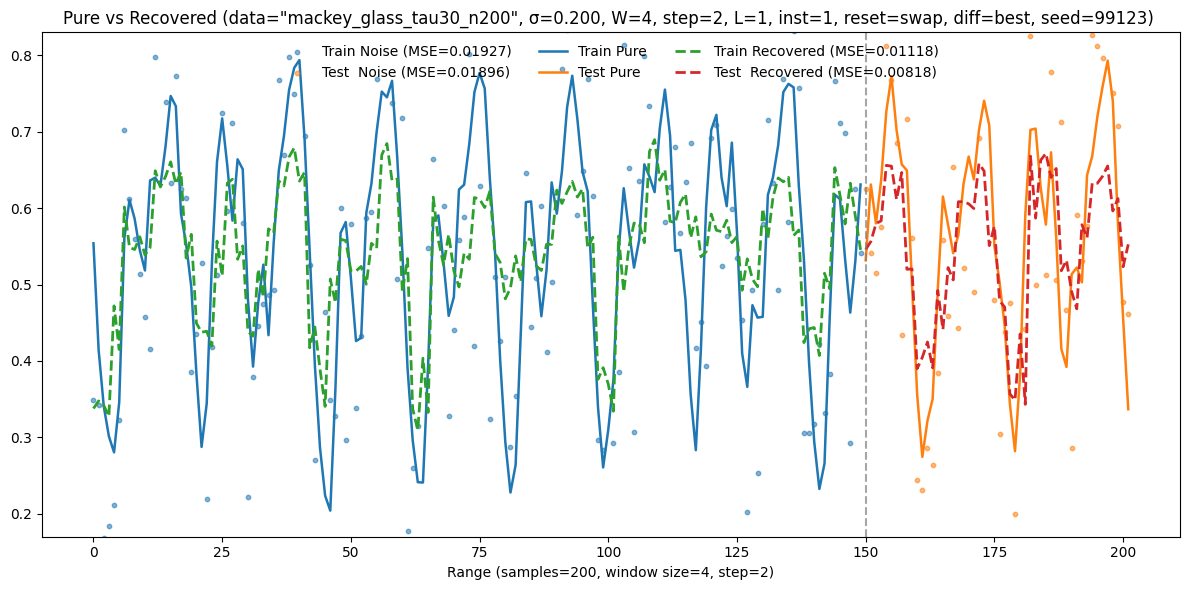


=== Final plot for L=1, inst=2 ===
[Series-avg] TRAIN: noise=0.01926807  recovered=0.01118466  Δ=+42.0%
[Series-avg] TEST : noise=0.01895794  recovered=0.00811033  Δ=+57.2%
Saved plot → aintern/figures/tau30/4q_3l_1t/L1/plot_4q_3l_1t_L1_inst02.png


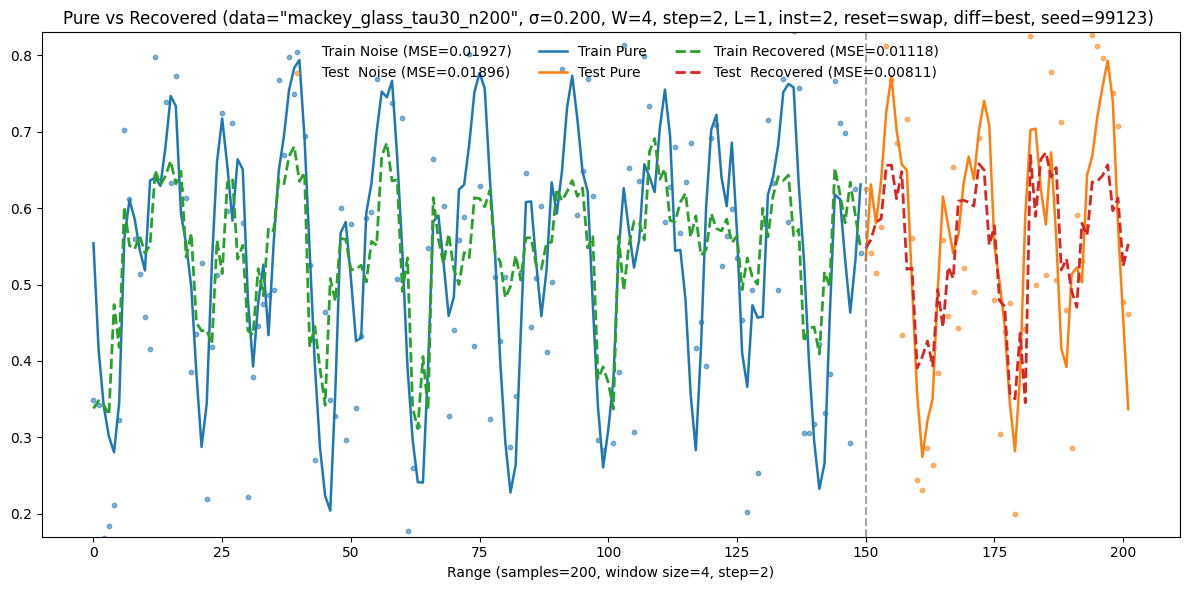


=== Final plot for L=1, inst=3 ===
[Series-avg] TRAIN: noise=0.01926807  recovered=0.01119283  Δ=+41.9%
[Series-avg] TEST : noise=0.01895794  recovered=0.00818144  Δ=+56.8%
Saved plot → aintern/figures/tau30/4q_3l_1t/L1/plot_4q_3l_1t_L1_inst03.png


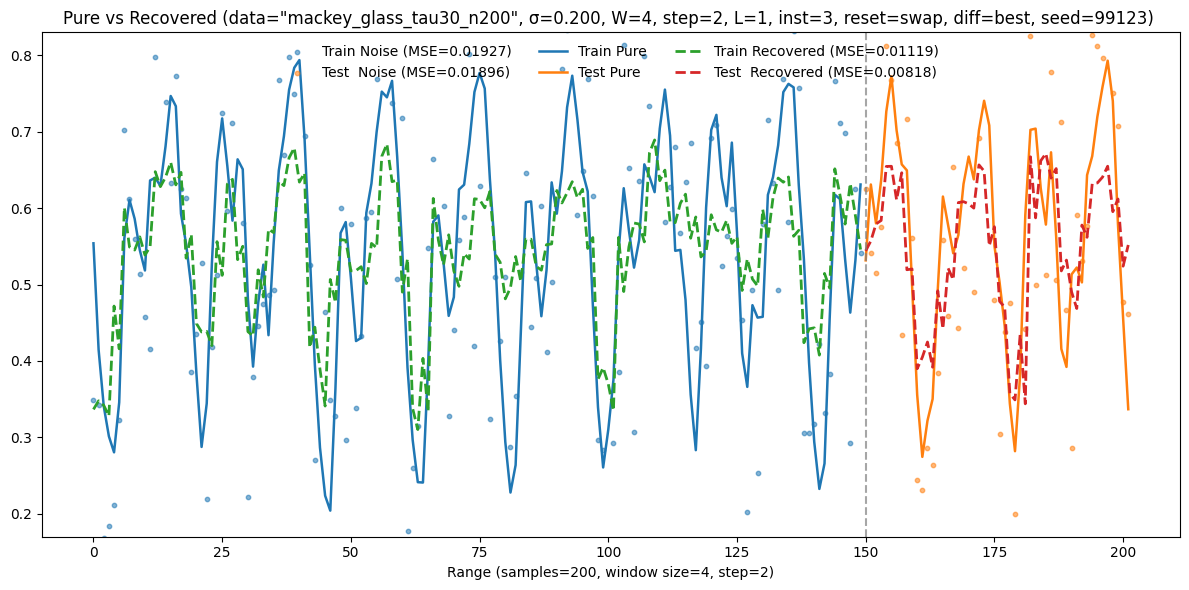


=== Final plot for L=1, inst=4 ===
[Series-avg] TRAIN: noise=0.01926807  recovered=0.01118761  Δ=+41.9%
[Series-avg] TEST : noise=0.01895794  recovered=0.00812206  Δ=+57.2%
Saved plot → aintern/figures/tau30/4q_3l_1t/L1/plot_4q_3l_1t_L1_inst04.png


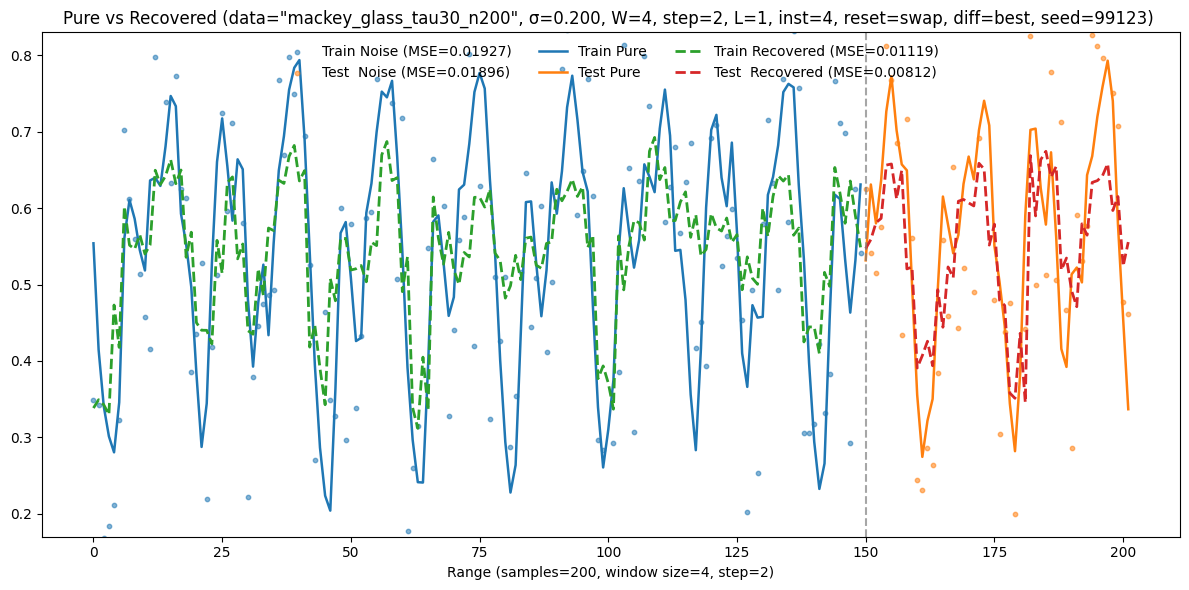


=== Final plot for L=1, inst=5 ===
[Series-avg] TRAIN: noise=0.01926807  recovered=0.01132349  Δ=+41.2%
[Series-avg] TEST : noise=0.01895794  recovered=0.00808447  Δ=+57.4%
Saved plot → aintern/figures/tau30/4q_3l_1t/L1/plot_4q_3l_1t_L1_inst05.png


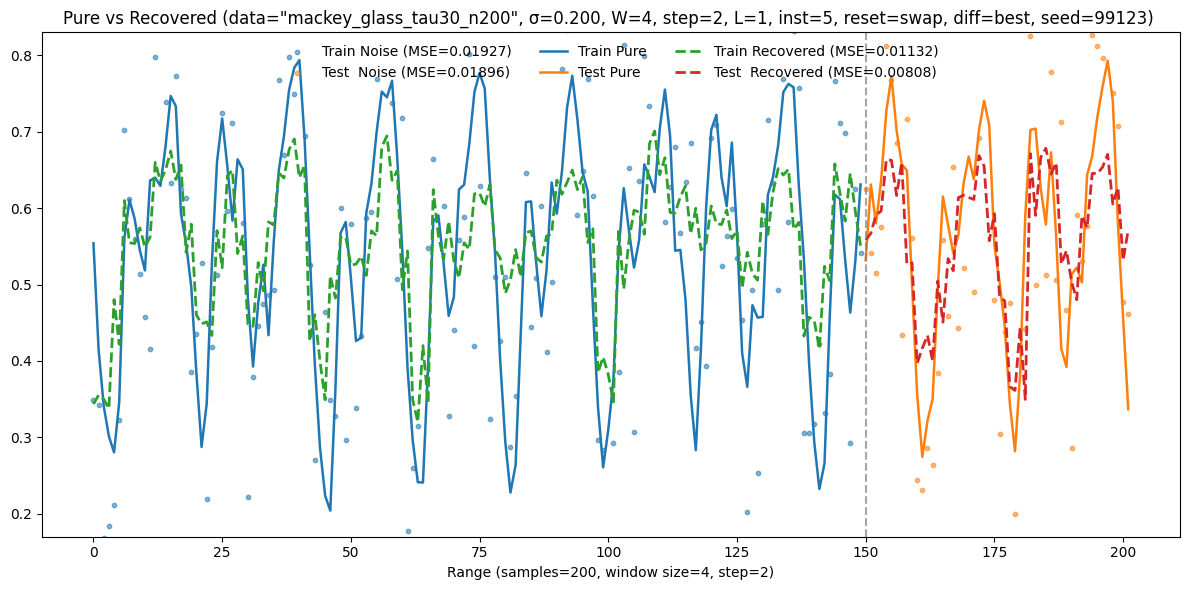


=== Final plot for L=3, inst=1 ===
[Series-avg] TRAIN: noise=0.01926807  recovered=0.00692645  Δ=+64.1%
[Series-avg] TEST : noise=0.01895794  recovered=0.00557057  Δ=+70.6%
Saved plot → aintern/figures/tau30/4q_3l_1t/L3/plot_4q_3l_1t_L3_inst01.png


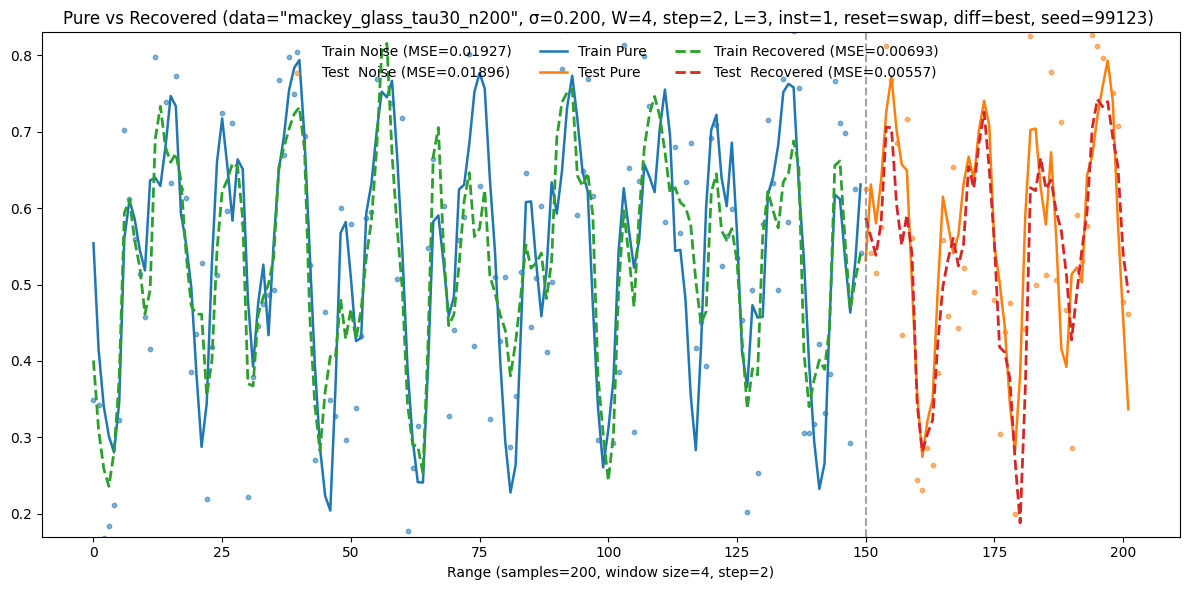


=== Final plot for L=3, inst=2 ===
[Series-avg] TRAIN: noise=0.01926807  recovered=0.00688031  Δ=+64.3%
[Series-avg] TEST : noise=0.01895794  recovered=0.00530695  Δ=+72.0%
Saved plot → aintern/figures/tau30/4q_3l_1t/L3/plot_4q_3l_1t_L3_inst02.png


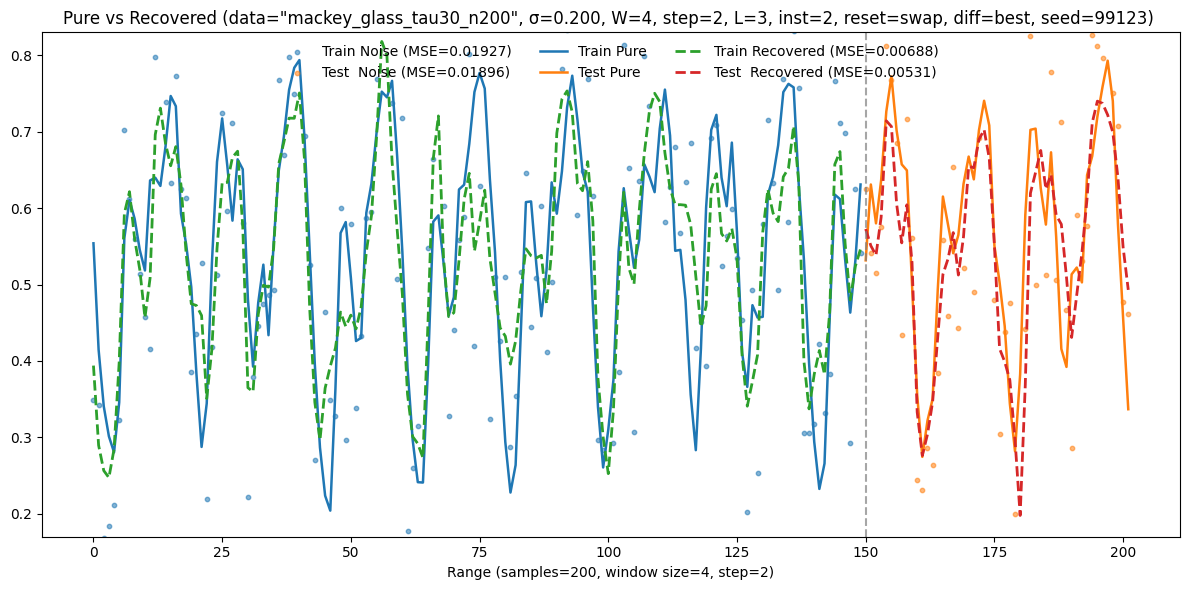


=== Final plot for L=3, inst=3 ===
[Series-avg] TRAIN: noise=0.01926807  recovered=0.00675488  Δ=+64.9%
[Series-avg] TEST : noise=0.01895794  recovered=0.00559122  Δ=+70.5%
Saved plot → aintern/figures/tau30/4q_3l_1t/L3/plot_4q_3l_1t_L3_inst03.png


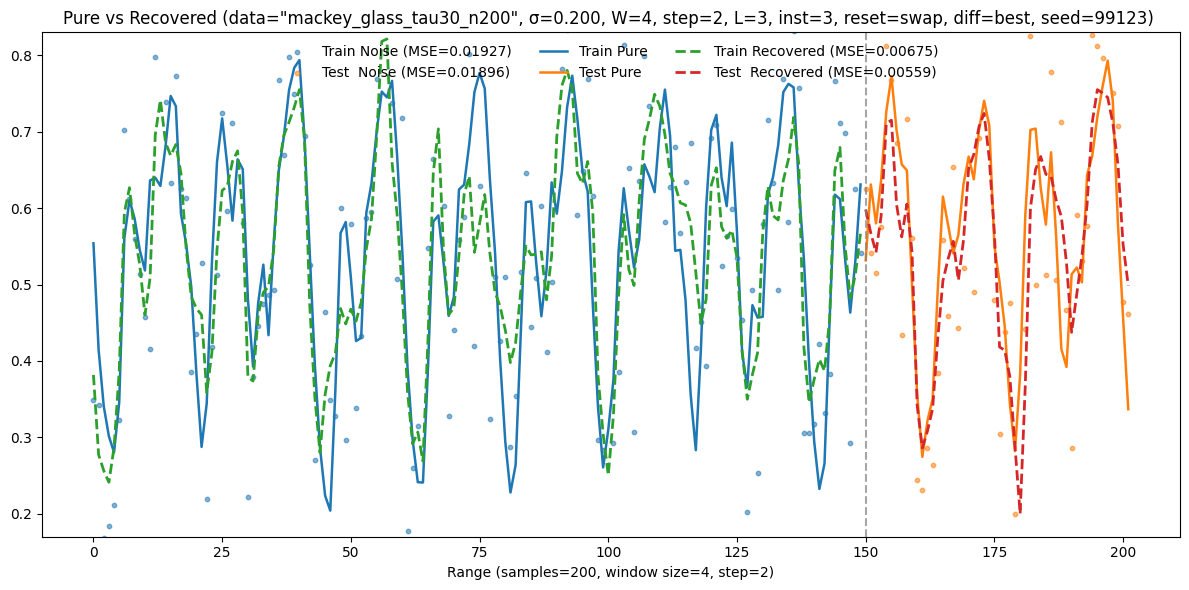


=== Final plot for L=3, inst=4 ===
[Series-avg] TRAIN: noise=0.01926807  recovered=0.00677496  Δ=+64.8%
[Series-avg] TEST : noise=0.01895794  recovered=0.00586281  Δ=+69.1%
Saved plot → aintern/figures/tau30/4q_3l_1t/L3/plot_4q_3l_1t_L3_inst04.png


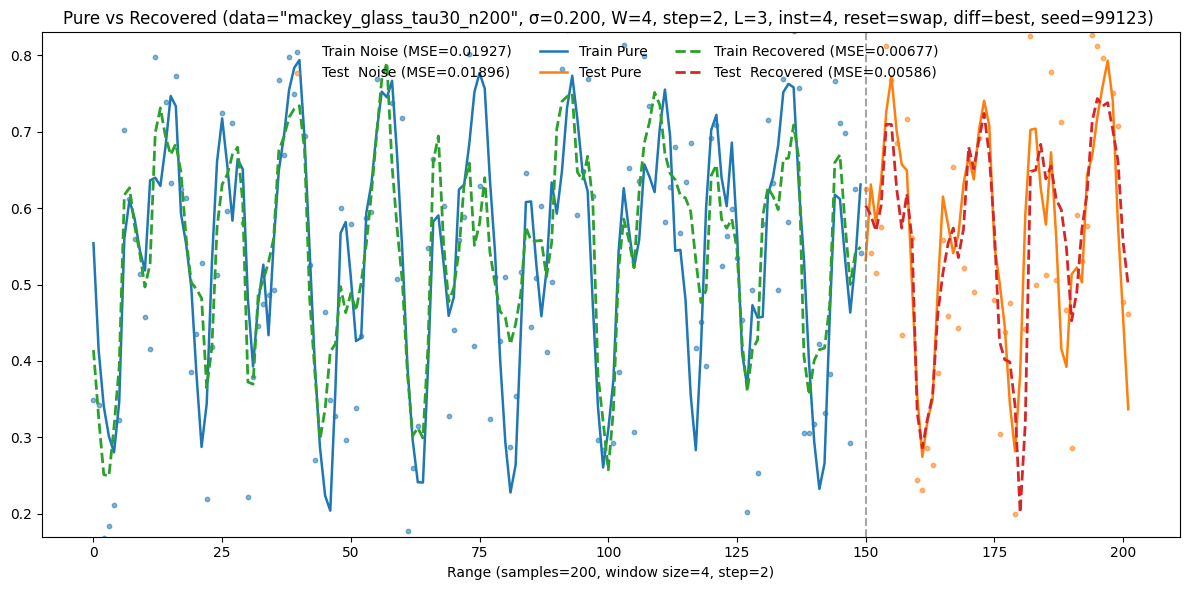


=== Final plot for L=3, inst=5 ===
[Series-avg] TRAIN: noise=0.01926807  recovered=0.00674264  Δ=+65.0%
[Series-avg] TEST : noise=0.01895794  recovered=0.00578157  Δ=+69.5%
Saved plot → aintern/figures/tau30/4q_3l_1t/L3/plot_4q_3l_1t_L3_inst05.png


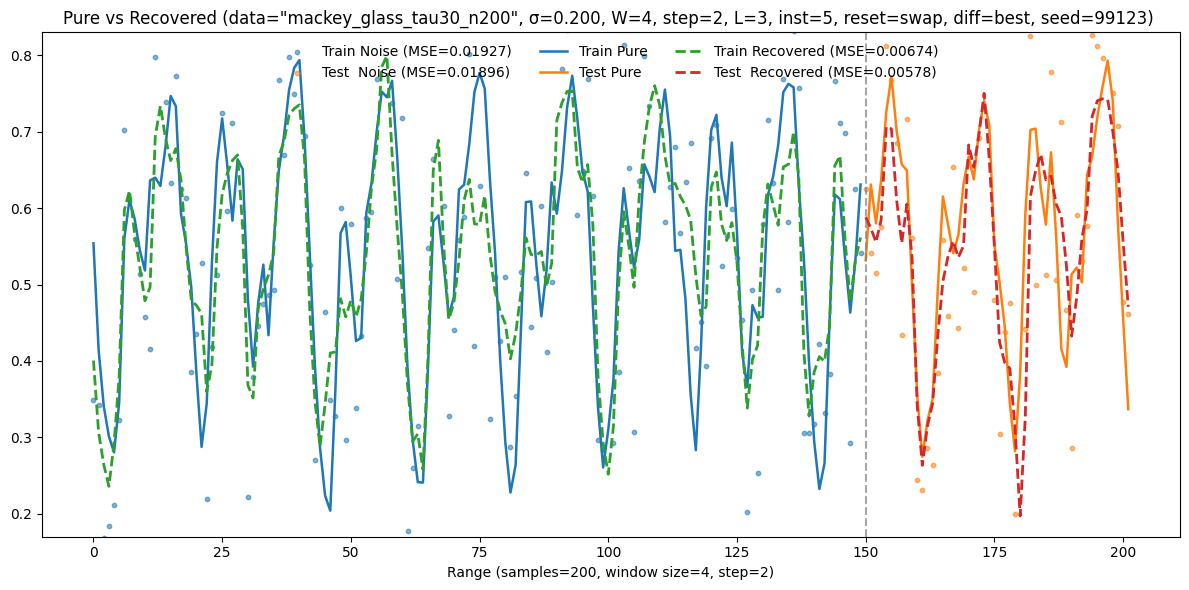

In [8]:
# ===========================
# Cell 7 — Final reconstruction plots per instance
# ===========================
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

INPUT_ENCODING = "raw"
RESET_MODE_FOR_EVAL = RESET_MODE
DIFF_METHOD_REQUESTED = DIFF_METHOD_REQUESTED if "DIFF_METHOD_REQUESTED" in globals() else "adjoint"
SIM_BACKEND = SIM_BACKEND if "SIM_BACKEND" in globals() else "lightning.qubit"

def _flatten_avg(windows):
    return ts_wind_flatten_avg(np.asarray(windows), wind_step)

def _mse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.mean((a - b) ** 2))

def windows_from_seed(y_vec, sigma, seed):
    y_noisy = ts_add_noise(
        y_vec, noise=sigma, noise_type='normal', clip=False,
        range_low=scale_low, range_high=scale_high, seed=seed
    )
    win_clean = ts_wind_make(y_vec,   wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(win_clean))])
    _, tr_clean, _, te_clean = ts_wind_split(X_ts, win_clean, split)
    _, tr_noisy, _, te_noisy = ts_wind_split(X_ts, win_noisy, split)
    return tr_clean, tr_noisy, te_clean, te_noisy

def choose_diff_method(reset_mode, req="adjoint"):
    if reset_mode == "swap" and req == "adjoint":
        return "adjoint"
    return "best"

def _sequence_encoder_RAW(wires, inputs):
    for i, w in enumerate(wires):
        qml.RY(inputs[i] if i < len(inputs) else 0.0, wires=w)

def _entangler(wires, weights, rot='Rxyz'):
    if rot == 'Ry':
        qml.BasicEntanglerLayers(weights, wires=wires, rotation=qml.RY)
    else:
        qml.StronglyEntanglingLayers(weights, wires=wires)

def _shape_layers(n_layers, n_wires, rot='Rxyz'):
    if rot == 'Ry':
        return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)

def make_full_qae_callable(
    wires, ancilla_wires,
    n_latent, n_trash, n_extra, n_layers=1, rot='Rxyz',
    add_outseq=False, invert_dec=True, reset_mode="measure",
    input_encoding="raw"
):
    latent_wires = wires[0:n_latent]
    trash_wires  = wires[n_latent:n_latent+n_trash]
    extra_wires  = wires[n_latent+n_trash:]
    data_wires   = latent_wires + trash_wires
    anz_wires    = latent_wires + trash_wires + extra_wires

    enc_shape = _shape_layers(n_layers, len(anz_wires), rot=rot)
    dec_shape = enc_shape

    def _full_qae(weights, inputs):
        enc_w = weights[:n_layers].reshape(enc_shape)
        dec_w = weights[n_layers:].reshape(dec_shape)

        if input_encoding == "raw":
            _sequence_encoder_RAW(data_wires, inputs)
        else:
            raise ValueError("Only 'raw' encoding used in mentor's notebook.")
        qml.Barrier(wires)

        _entangler(anz_wires, enc_w, rot=rot)

        # --- SWAP-reset both trash + extra in SWAP path; otherwise measure+reset ---
        qml.Barrier(wires)
        if reset_mode == "swap":
            anc_trash = ancilla_wires[:n_trash]
            anc_extra = ancilla_wires[n_trash:n_trash + n_extra]
            for t, a in zip(trash_wires, anc_trash): qml.SWAP(wires=[t, a])
            for e, a in zip(extra_wires, anc_extra): qml.SWAP(wires=[e, a])
        else:
            for w in trash_wires: qml.measure(w, reset=True)
            for w in extra_wires: qml.measure(w, reset=True)
        qml.Barrier(wires)

        if invert_dec:
            qml.adjoint(_entangler)(anz_wires, dec_w, rot=rot)
        else:
            _entangler(anz_wires, enc_w, rot=rot)
        qml.Barrier(wires)

        if add_outseq:
            _sequence_encoder_RAW(data_wires, inputs)

        return [qml.expval(qml.PauliZ(w)) for w in data_wires]

    return _full_qae

def run_qnode_series(qnode, weights, windows):
    outs = []
    for w in windows:
        z = qnode(weights, w)       # ⟨Z⟩ in [-1, 1]
        outs.append(np.asarray(z))
    return np.stack(outs)

def plot_reconstruction(weights_vec, L, inst, reset_mode, diff_req="adjoint", save_dir=None, title_note=""):
    base = list(range(n_latent + n_trash + n_extra))

    n_anc = (n_trash + n_extra) if reset_mode == "swap" else 0
    ancilla_wires = list(range(len(base), len(base) + n_anc))
    dev = qml.device(SIM_BACKEND, wires=len(base) + n_anc, shots=None)

    qae_call = make_full_qae_callable(
        wires=base, ancilla_wires=ancilla_wires,
        n_latent=n_latent, n_trash=n_trash, n_extra=n_extra,
        n_layers=L, rot=rot, add_outseq=False, invert_dec=True,
        reset_mode=reset_mode, input_encoding=INPUT_ENCODING
    )
    diff_method = choose_diff_method(reset_mode, diff_req)
    qae_model = qml.QNode(qae_call, dev) #, interface="autograd", diff_method=diff_method)

    tr_c, tr_n, te_c, te_n = windows_from_seed(y, EVAL_SIGMA, TEST_SEED_FIXED)

    tr_rec = run_qnode_series(qae_model, weights_vec, tr_n)
    te_rec = run_qnode_series(qae_model, weights_vec, te_n)

    tr_pure = _flatten_avg(tr_c);  te_pure = _flatten_avg(te_c)
    tr_noi  = _flatten_avg(tr_n);  te_noi  = _flatten_avg(te_n)
    tr_hat  = _flatten_avg(tr_rec);te_hat  = _flatten_avg(te_rec)

    mse_tr_noise = _mse(tr_pure, tr_noi)
    mse_te_noise = _mse(te_pure, te_noi)
    mse_tr_hat   = _mse(tr_pure, tr_hat)
    mse_te_hat   = _mse(te_pure, te_hat)

    d_tr = 100.0 * (1.0 - mse_tr_hat / max(mse_tr_noise, 1e-12))
    d_te = 100.0 * (1.0 - mse_te_hat / max(mse_te_noise, 1e-12))
    print(f"[Series-avg] TRAIN: noise={mse_tr_noise:0.8f}  recovered={mse_tr_hat:0.8f}  Δ={d_tr:+.1f}%")
    print(f"[Series-avg] TEST : noise={mse_te_noise:0.8f}  recovered={mse_te_hat:0.8f}  Δ={d_te:+.1f}%")

    x_tr = np.arange(len(tr_pure)); x_te = np.arange(len(tr_pure), len(tr_pure)+len(te_pure))
    x_split = len(tr_pure)

    plt.figure(figsize=(12, 6))
    plt.scatter(x_tr, tr_noi, s=10, alpha=0.55, label=f"Train Noise (MSE={mse_tr_noise:0.5f})")
    plt.scatter(x_te, te_noi, s=10, alpha=0.55, label=f"Test  Noise (MSE={mse_te_noise:0.5f})")
    plt.plot(x_tr, tr_pure, linewidth=1.8, label="Train Pure")
    plt.plot(x_te, te_pure, linewidth=1.8, label="Test Pure")
    plt.plot(x_tr, tr_hat, linestyle="--", linewidth=2.0, label=f"Train Recovered (MSE={mse_tr_hat:0.5f})")
    plt.plot(x_te, te_hat, linestyle="--", linewidth=2.0, label=f"Test  Recovered (MSE={mse_te_hat:0.5f})")
    plt.axvline(x_split, color="grey", linestyle="--", alpha=0.7)
    plt.ylim(scale_low - 0.05*(scale_high - scale_low), scale_high + 0.05*(scale_high - scale_low))
    plt.xlabel(f'Range (samples={len(y)}, window size={wind_size}, step={wind_step})')
    plt.title(
        f'Pure vs Recovered (data="{DATA_ID}", σ={EVAL_SIGMA:.3f}, W={wind_size}, '
        f'step={wind_step}, L={L}, inst={inst}, reset={reset_mode}, '
        f'diff={diff_method}, seed={TEST_SEED_FIXED}) {title_note}'
    )
    plt.legend(loc="upper center", ncol=3, frameon=False)
    plt.tight_layout()

    if SAVE_PLOTS and save_dir:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        out_png = Path(save_dir) / f"plot_{arch_tag()}_L{L}_inst{inst:02d}.png"
        plt.savefig(out_png, dpi=200, bbox_inches="tight", pad_inches=0.08)
        print(f"Saved plot → {out_png}")
    plt.show()

# ---- render all instances we have weights for
for L in LAYER_OPTIONS:
    layer_dir = f"{FIGURES_PATH}/tau30/{arch_tag()}/L{L}"
    for inst in INSTANCES_PER_LAYER:
        weights_path = Path(BUNDLE_ROOT) / DATA_ID / arch_tag() / f"L{L}" / f"weights_inst{inst:02d}_L{L}.npy"
        if weights_path.exists():
            w = np.load(weights_path)
            print(f"\n=== Final plot for L={L}, inst={inst} ===")
            plot_reconstruction(w, L, inst, RESET_MODE_FOR_EVAL, diff_req=DIFF_METHOD_REQUESTED, save_dir=layer_dir)

## System (Linux)

In [9]:
import sys
print(f'\nEnvironment:\n\n{sys.prefix}\n')


Environment:

/home/jacob/miniconda3/envs/pl-cuda12



In [10]:
import os
print(f"\nSignificant packages:\n")
os.system('pip list | grep -e pennylane');


Significant packages:

pennylane                 0.42.3
pennylane_lightning       0.42.0
